<a href="https://colab.research.google.com/github/vphcap-res/DOA_deep_learning/blob/main/DOA_MeatDuck_SHAP_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Import and Preprocessing**

In [1]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Read the file (update path accordingly)
file_path = "/content/drive/My Drive/DOA-MeatDucks-SHAP/DOA-data_65-66.xlsx"
df = pd.read_excel(file_path)

# Display first few rows
df.head()

# n = 9532

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,date,order,farmth,farm,distance,head,age,bw,timeoutfarm,timearrive,slaughtertime,lairagetemp,doa,%doa
0,2022-01-04,1,ประวัติฟาร์ม,Pravatfarm,130.0,1200,43,3.18,01:00:00,03:00:00,05:30:00,24.0,0,0.000000
1,2022-01-04,2,ประวัติฟาร์ม,Pravatfarm,130.0,1200,43,3.12,01:50:00,04:10:00,06:05:00,24.0,0,0.000000
2,2022-01-04,3,ประวัติฟาร์ม,Pravatfarm,130.0,1200,43,3.15,02:40:00,06:00:00,06:40:00,0.0,1,0.083333
3,2022-01-04,4,ประวัติฟาร์ม,Pravatfarm,130.0,1100,43,3.20,03:30:00,06:14:00,07:14:00,25.4,1,0.090909
4,2022-01-04,5,ประวัติฟาร์ม,Pravatfarm,130.0,1028,43,3.04,04:20:00,06:27:00,07:47:00,25.6,1,0.106045


In [2]:
# ==============================================
# 📌 1. BASIC LIBRARIES
# ==============================================
import pandas as pd  # Data manipulation
import numpy as np  # Numerical operations
import os  # File operations

# ==============================================
# 📌 2. DATA VISUALIZATION
# ==============================================
import matplotlib.pyplot as plt  # General plotting
import seaborn as sns  # Statistical visualization

# ==============================================
# 📌 3. DATA PREPROCESSING
# ==============================================
from sklearn.model_selection import train_test_split  # Splitting dataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler  # Feature scaling
from sklearn.impute import SimpleImputer  # Handling missing values
from sklearn.utils import resample  # For upsampling and downsampling

# ==============================================
# 📌 4. MACHINE LEARNING MODELS
# ==============================================
from sklearn.linear_model import LogisticRegression  # Baseline model
from sklearn.ensemble import RandomForestClassifier  # Random Forest
from xgboost import XGBClassifier  # XGBoost
from sklearn.svm import SVC  # Support Vector Machine
from sklearn.tree import DecisionTreeClassifier  # Decision Tree
from sklearn.neural_network import MLPClassifier  # Neural Network

# ==============================================
# 📌 5. RESAMPLING TECHNIQUES (Handling Imbalanced Data)
# ==============================================
from imblearn.over_sampling import SMOTE  # Synthetic Minority Oversampling
from imblearn.over_sampling import RandomOverSampler  # Random Oversampling
from imblearn.under_sampling import RandomUnderSampler  # Random Undersampling

# ==============================================
# 📌 6. MODEL EVALUATION
# ==============================================
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix
)  # Evaluation metrics

# ==============================================
# 📌 7. FEATURE IMPORTANCE & INTERPRETABILITY
# ==============================================
import shap  # SHAP values for feature importance
from sklearn.inspection import permutation_importance  # Permutation feature importance
!pip install --upgrade pdpbox
from pdpbox import pdp, info_plots

**Data Preprocessing**

In [3]:
# 1. Remove rows where 'head' is 0 or greater than 1900
df = df[(df['head'] > 0) & (df['head'] <= 1900)]
# n = 9515

In [4]:
# 2. Remove rows where 'age' is 3 or greater than 47
df = df[(df['age'] > 3) & (df['age'] <= 47)]
# n = 9502

In [5]:
# 3. Remove rows where 'bw' is less than 2
df = df[df['bw'] >= 2]
# n = 9403

In [6]:
# 4. Remove rows where 'lairagetemp' is 0 or greater than 39
df = df[(df['lairagetemp'] > 0) & (df['lairagetemp'] <= 39)]
# n = 8229

In [7]:
# 5. Remove rows where 'doa' is greater than 50
df = df[df['doa'] <= 50]
# n = 8223

In [8]:
# Save cleaned dataset
cleaned_file_path = "/content/drive/My Drive/DOA-MeatDucks-SHAP/DOA-data_65-66_cleaned.xlsx"
df.to_excel(cleaned_file_path, index=False)

In [9]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)
df['distance'] = imputer.fit_transform(df[['distance']])

In [10]:
# Save imputed dataset
imputed_file_path = "/content/drive/My Drive/DOA-MeatDucks-SHAP/DOA-data_65-66_cleaned_imputed.xlsx"
df.to_excel(imputed_file_path, index=False)

**Feature Engineering**

In [11]:
import pandas as pd

# ==========================
# 🔹 CREATE A COPY OF THE DATAFRAME TO AVOID OVERWRITING
# ==========================
df2 = df.copy()

# ==========================
# 🔹 REMOVE UNNEEDED COLUMNS
# ==========================
df2.drop(columns=['%doa', 'farmth'], inplace=True, errors='ignore')

# ==========================
# 🔹 ADD NEW FEATURES
# ==========================

# 1️⃣ Add 'pctdoa' (Percentage of DOA)
df2['pctdoa'] = (df2['doa'] / df2['head']) * 100

# 2️⃣ Transform 'order' into categorical 'orderc'
def categorize_order(order):
    if order <= 5:
        return "Early"
    elif order <= 10:
        return "Middle"
    else:
        return "Late"

df2['orderc'] = df2['order'].apply(categorize_order)

# 3️⃣ Add 'season' from 'date'
df2['date'] = pd.to_datetime(df2['date'])  # Ensure 'date' is in datetime format

def get_season(month):
    if month in [11, 12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Summer'
    else:
        return 'Rainy'

df2['season'] = df2['date'].dt.month.apply(get_season)

# 4️⃣ Add 'timetransport' from 'timeoutfarm'
df2['timeoutfarm'] = pd.to_datetime(df2['timeoutfarm'], format='%H:%M:%S', errors='coerce')  # Ensure datetime format

def get_time_category(hour):
    if 18 <= hour or hour < 4:
        return 'Night'
    elif 4 <= hour < 8:
        return 'Morning'
    else:
        return 'Day'

df2['timetransport'] = df2['timeoutfarm'].dt.hour.apply(get_time_category)

# ==========================
# 🔹 DISPLAY TRANSFORMED DATA
# ==========================
print("✅ Feature engineering completed on df2. Preview of new columns:\n")
print(df2[['order', 'orderc', 'season', 'timetransport']].head())

# ==========================
# 🔹 SAVE UPDATED DATASET
# ==========================
updated_file_path = "/content/drive/My Drive/DOA-MeatDucks-SHAP/DOA-data_65-66_featured.xlsx"
df2.to_excel(updated_file_path, index=False)

print(f"\n✅ New dataset (df2) with feature engineering saved to: {updated_file_path}")

✅ Feature engineering completed on df2. Preview of new columns:

   order  orderc  season timetransport
0      1   Early  Winter         Night
1      2   Early  Winter         Night
3      4   Early  Winter         Night
4      5   Early  Winter       Morning
5      6  Middle  Winter       Morning

✅ New dataset (df2) with feature engineering saved to: /content/drive/My Drive/DOA-MeatDucks-SHAP/DOA-data_65-66_featured.xlsx


In [12]:
import pandas as pd

# ==========================
# 🔹 CREATE A COPY OF THE DATAFRAME (df3)
# ==========================
df3 = df2.copy()

# ==========================
# 🔹 ENSURE TIME COLUMNS ARE IN DATETIME FORMAT
# ==========================
df3['timeoutfarm'] = pd.to_datetime(df3['timeoutfarm'], format='%H:%M:%S', errors='coerce')
df3['timearrive'] = pd.to_datetime(df3['timearrive'], format='%H:%M:%S', errors='coerce')
df3['slaughtertime'] = pd.to_datetime(df3['slaughtertime'], format='%H:%M:%S', errors='coerce')

# ==========================
# 🔹 FUNCTION TO CALCULATE TIME DIFFERENCES
# ==========================
def calculate_duration(start_time, end_time):
    if pd.notna(start_time) and pd.notna(end_time):  # Ensure times are not NaN
        if end_time < start_time:  # Case when arrival happens after midnight
            end_time += pd.Timedelta(days=1)
        return (end_time - start_time).seconds / 60  # Convert to minutes
    return None  # Return None if either value is NaN

# ==========================
# 🔹 CALCULATE 'durationtransport'
# ==========================
df3['durationtransport'] = df3.apply(lambda row: calculate_duration(row['timeoutfarm'], row['timearrive']), axis=1)

# ==========================
# 🔹 CALCULATE 'lairagetime'
# ==========================
df3['lairagetime'] = df3.apply(lambda row: calculate_duration(row['timearrive'], row['slaughtertime']), axis=1)

# ==========================
# 🔹 REMOVE UNWANTED DATA POINTS
# ==========================
df3 = df3[(df3['durationtransport'] > 0) & (df3['durationtransport'] <= 500)]

# ==========================
# 🔹 DISPLAY TRANSFORMED DATA
# ==========================
print("✅ Time calculations completed. Preview of new columns:\n")
print(df3[['timeoutfarm', 'timearrive', 'durationtransport', 'slaughtertime', 'lairagetime']].head())

# ==========================
# 🔹 SAVE UPDATED DATASET (df3)
# ==========================
updated_file_path = "/content/drive/My Drive/DOA-MeatDucks-SHAP/DOA-data_65-66_final_filtered.xlsx"
df3.to_excel(updated_file_path, index=False)

print(f"\n✅ Dataset (df3) with computed durations and filtered data saved to: {updated_file_path}")

✅ Time calculations completed. Preview of new columns:

          timeoutfarm          timearrive  durationtransport  \
0 1900-01-01 01:00:00 1900-01-01 03:00:00              120.0   
1 1900-01-01 01:50:00 1900-01-01 04:10:00              140.0   
3 1900-01-01 03:30:00 1900-01-01 06:14:00              164.0   
4 1900-01-01 04:20:00 1900-01-01 06:27:00              127.0   
5 1900-01-01 05:45:00 1900-01-01 07:19:00               94.0   

        slaughtertime  lairagetime  
0 1900-01-01 05:30:00        150.0  
1 1900-01-01 06:05:00        115.0  
3 1900-01-01 07:14:00         60.0  
4 1900-01-01 07:47:00         80.0  
5 1900-01-01 08:27:00         68.0  

✅ Dataset (df3) with computed durations and filtered data saved to: /content/drive/My Drive/DOA-MeatDucks-SHAP/DOA-data_65-66_final_filtered.xlsx


Check class imbalance

Encode Categorical Variables

In [13]:
df3 = pd.get_dummies(df3, columns=['season', 'timetransport', 'orderc'], drop_first=True)

**%DOA**

In [14]:
print(df3.columns)  # List all column names

Index(['date', 'order', 'farm', 'distance', 'head', 'age', 'bw', 'timeoutfarm',
       'timearrive', 'slaughtertime', 'lairagetemp', 'doa', 'pctdoa',
       'durationtransport', 'lairagetime', 'season_Summer', 'season_Winter',
       'timetransport_Morning', 'timetransport_Night', 'orderc_Late',
       'orderc_Middle'],
      dtype='object')


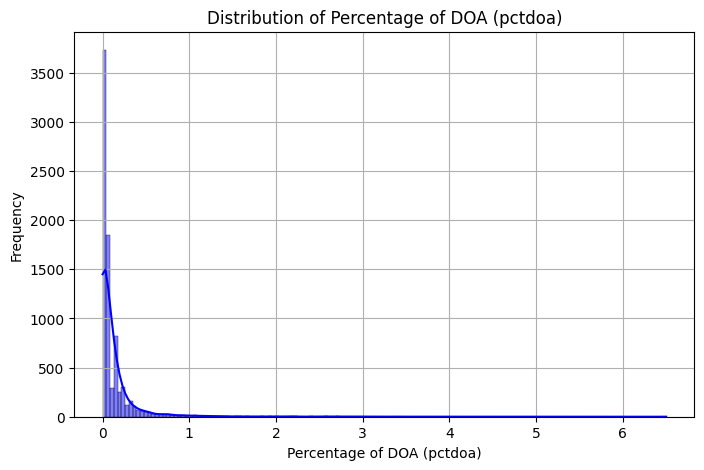

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of 'pctdoa'
plt.figure(figsize=(8, 5))
sns.histplot(df3['pctdoa'], bins=150, kde=True, color="blue")  # KDE for smoother distribution
plt.xlabel("Percentage of DOA (pctdoa)")
plt.ylabel("Frequency")
plt.title("Distribution of Percentage of DOA (pctdoa)")
plt.grid(True)
plt.show()


In [16]:
import pandas as pd

# Define different threshold methods for High DOA classification

# 1️⃣ Median-Based Threshold
median_threshold = df3['pctdoa'].median()
df3['highdoa_median'] = (df3['pctdoa'] > median_threshold).astype(int)

# 2️⃣ Mean + Standard Deviation (SD) Threshold
mean_value = df3['pctdoa'].mean()
std_dev = df3['pctdoa'].std()
sd_threshold = mean_value + std_dev
df3['highdoa_sd'] = (df3['pctdoa'] > sd_threshold).astype(int)

# 3️⃣ Top 25% Quantile-Based Cutoff (High-Risk Group)
quantile_threshold = df3['pctdoa'].quantile(0.75)
df3['highdoa_quantile'] = (df3['pctdoa'] > quantile_threshold).astype(int)

# 4️⃣ Domain-Expert Defined Threshold (Example: 0.15% DOA is critical)
industry_threshold = 0.15  # Modify based on domain knowledge
df3['highdoa_industry'] = (df3['pctdoa'] > industry_threshold).astype(int)

# Summarize the number of data points assigned to High DOA and Low DOA for each method
summary_df = pd.DataFrame({
    "Method": ["Median-Based", "Mean + SD", "Top 25% Quantile", "Industry Standard (0.15%)"],
    "High DOA Count": [
        df3['highdoa_median'].sum(),
        df3['highdoa_sd'].sum(),
        df3['highdoa_quantile'].sum(),
        df3['highdoa_industry'].sum()
    ],
    "Low DOA Count": [
        len(df3) - df3['highdoa_median'].sum(),
        len(df3) - df3['highdoa_sd'].sum(),
        len(df3) - df3['highdoa_quantile'].sum(),
        len(df3) - df3['highdoa_industry'].sum()
    ]
})

# Display the summary
print(summary_df)

                      Method  High DOA Count  Low DOA Count
0               Median-Based            4079           4141
1                  Mean + SD             504           7716
2           Top 25% Quantile            1779           6441
3  Industry Standard (0.15%)            2157           6063


**Top 25% Quantile-Based Cutoff (High-Risk Group)**

In [17]:
threshold = df3['pctdoa'].quantile(0.75)
df3['highdoa'] = (df3['pctdoa'] > threshold).astype(int)

In [18]:
df3['highdoa'].value_counts(normalize=True)

,proportion
highdoa,
0,0.783577
1,0.216423


In [19]:
# Create df4 as a copy of df3 to avoid modifying the original dataset
df4 = df3.copy()

# List of columns to remove
columns_to_remove = [
    'date', 'order', 'farm', 'timeoutfarm', 'timearrive', 'slaughtertime',
    'doa', 'pctdoa', 'highdoa_median', 'highdoa_sd', 'highdoa_quantile', 'highdoa_industry'
]

# Drop the specified columns
df4.drop(columns=columns_to_remove, inplace=True, errors='ignore')

# Display the first few rows to confirm changes
print("✅ Columns removed successfully. Preview of df4:\n")
print(df4.head())

✅ Columns removed successfully. Preview of df4:

   distance  head  age    bw  lairagetemp  durationtransport  lairagetime  \
0     130.0  1200   43  3.18         24.0              120.0        150.0   
1     130.0  1200   43  3.12         24.0              140.0        115.0   
3     130.0  1100   43  3.20         25.4              164.0         60.0   
4     130.0  1028   43  3.04         25.6              127.0         80.0   
5      55.0  1300   43  3.37         24.2               94.0         68.0   

   season_Summer  season_Winter  timetransport_Morning  timetransport_Night  \
0          False           True                  False                 True   
1          False           True                  False                 True   
3          False           True                  False                 True   
4          False           True                   True                False   
5          False           True                   True                False   

   orderc_Lat

# **Data Splitting**

**1. Data Splitting**

In [20]:
from sklearn.model_selection import train_test_split

# Define feature matrix (X) and target variable (y)
X = df4.drop(columns=['highdoa'])  # Drop the target column
y = df4['highdoa']  # Target variable

# Split the dataset into train (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Check class distribution
print("Class distribution in training set:\n", y_train.value_counts(normalize=True))
print("\nClass distribution in testing set:\n", y_test.value_counts(normalize=True))

Class distribution in training set:
 highdoa
0    0.783607
1    0.216393
Name: proportion, dtype: float64

Class distribution in testing set:
 highdoa
0    0.783455
1    0.216545
Name: proportion, dtype: float64


**2. Check for Class Imbalance**

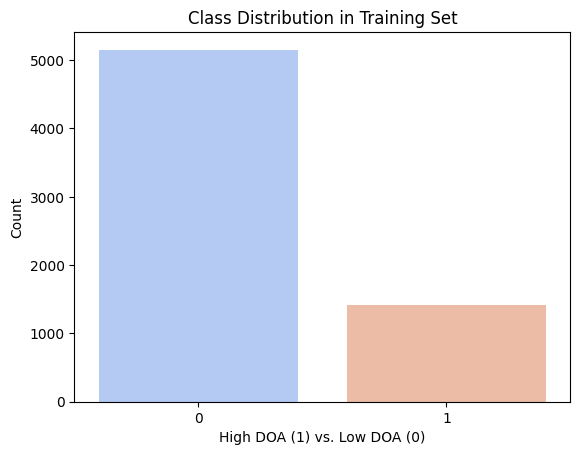

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualizing class distribution
sns.countplot(x=y_train, palette="coolwarm")
plt.title("Class Distribution in Training Set")
plt.xlabel("High DOA (1) vs. Low DOA (0)")
plt.ylabel("Count")
plt.show()

# **Implementing Cost-Sensitive Learning for Handling Imbalanced Data**
**Compute class weight**

In [22]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

print("Computed Class Weights:", class_weight_dict)

Computed Class Weights: {0: 0.638074907820687, 1: 2.3106113843991567}


# **Implement Upsampling for Imbalanced Data**

In [23]:
from imblearn.over_sampling import RandomOverSampler, SMOTE

# Apply Random Oversampling
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# **Model Training**

**Step 1: Set Up K-Fold Cross-Validation**

In [24]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Set up 10-fold stratified cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

**Logistic Regression (with Class Weights) -- Baseline model**

In [27]:
!pip uninstall -y scikit-learn

Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1


In [28]:
!pip install scikit-learn==1.5.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 34.6 MB/s eta 0:00:00


In [25]:
from sklearn.linear_model import LogisticRegression

# Define model
model_lr = LogisticRegression(class_weight="balanced", random_state=42)

# Perform 10-fold cross-validation
scores_lr = cross_val_score(model_lr, X_train, y_train, cv=cv, scoring='f1')

# Print results
print(f"Logistic Regression - Mean F1 Score: {scores_lr.mean():.4f}")

Logistic Regression - Mean F1 Score: 0.4635


**Random Forest (with Class Weights)**

In [26]:
from sklearn.ensemble import RandomForestClassifier

# Define model
model_rf = RandomForestClassifier(class_weight="balanced", random_state=42)

# Perform 10-fold cross-validation
scores_rf = cross_val_score(model_rf, X_train, y_train, cv=cv, scoring='f1')

# Print results
print(f"Random Forest - Mean F1 Score: {scores_rf.mean():.4f}")

Random Forest - Mean F1 Score: 0.4086


**XGBoost (Handling Class Imbalance via scale_pos_weight)**

In [27]:
import xgboost as xgb
import pandas as pd

# Convert dataset into DMatrix format (XGBoost's internal format)
dtrain = xgb.DMatrix(X_train, label=y_train)

# Define XGBoost parameters
params = {
    'objective': 'binary:logistic',
    'scale_pos_weight': y_train.value_counts()[0] / y_train.value_counts()[1],
    'eval_metric': 'logloss',
    'random_state': 42
}

# Perform XGBoost cross-validation
xgb_cv_results = xgb.cv(params, dtrain, num_boost_round=100, nfold=10, as_pandas=True, metrics="logloss")

# Display results
print(xgb_cv_results.head())

   train-logloss-mean  train-logloss-std  test-logloss-mean  test-logloss-std
0            0.619513           0.001700           0.629873          0.005187
1            0.575194           0.003299           0.594593          0.007104
2            0.543971           0.003031           0.573093          0.008939
3            0.520878           0.002910           0.558174          0.010583
4            0.502639           0.003867           0.548615          0.011166


# **Hyperparameter Tuning (Before Training Models)**

**Random Forest**

In [28]:
from sklearn.model_selection import GridSearchCV

# Random Forest Hyperparameter Tuning
param_grid_rf = {
    'n_estimators': [100, 200, 300],  # Number of trees
    'max_depth': [5, 10, 20],  # Depth of trees
    'min_samples_split': [2, 5, 10]  # Minimum samples per split
}

grid_search_rf = GridSearchCV(RandomForestClassifier(class_weight='balanced', random_state=42),
                              param_grid_rf, cv=5, scoring='f1')
grid_search_rf.fit(X_train, y_train)

# Use best parameters
model_rf = RandomForestClassifier(**grid_search_rf.best_params_, class_weight='balanced', random_state=42)
model_rf.fit(X_train, y_train)

print("Best Random Forest Parameters:", grid_search_rf.best_params_)

Best Random Forest Parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 300}


**XGBoost**

In [34]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 2.2 MB/s eta 0:00:00


In [29]:
import optuna
import xgboost as xgb
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

# Define objective function for Optuna
def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'scale_pos_weight': y_train.value_counts()[0] / y_train.value_counts()[1]
    }

    model = xgb.XGBClassifier(**params, use_label_encoder=False, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return f1_score(y_test, y_pred)

# Run Optuna optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

# Get best parameters
best_params = study.best_params
print("Best XGBoost Parameters:", best_params)

# Train final XGBoost model with best parameters
model_xgb = xgb.XGBClassifier(**best_params, use_label_encoder=False, random_state=42)
model_xgb.fit(X_train, y_train)

[I 2025-02-10 08:03:49,162] A new study created in memory with name: no-name-84312d9b-1ff9-48e2-a452-a5f8c75c5198
[I 2025-02-10 08:03:49,446] Trial 0 finished with value: 0.5481798715203426 and parameters: {'learning_rate': 0.013825699838114689, 'max_depth': 3, 'n_estimators': 326}. Best is trial 0 with value: 0.5481798715203426.
[I 2025-02-10 08:03:51,434] Trial 1 finished with value: 0.5227606461086637 and parameters: {'learning_rate': 0.26506597766565443, 'max_depth': 7, 'n_estimators': 285}. Best is trial 0 with value: 0.5481798715203426.
[I 2025-02-10 08:03:51,654] Trial 2 finished with value: 0.5724217844727694 and parameters: {'learning_rate': 0.08314183488901634, 'max_depth': 4, 'n_estimators': 226}. Best is trial 2 with value: 0.5724217844727694.
[I 2025-02-10 08:03:52,852] Trial 3 finished with value: 0.5570228091236494 and parameters: {'learning_rate': 0.12976258234528384, 'max_depth': 4, 'n_estimators': 332}. Best is trial 2 with value: 0.5724217844727694.
[I 2025-02-10 08:

Best XGBoost Parameters: {'learning_rate': 0.05236645228807308, 'max_depth': 5, 'n_estimators': 228}


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05236645228807308,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=228, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

**MLP Hyperparameter tuning**

In [34]:
import optuna

# Define the hyperparameter tuning function
def objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 0.0001, 0.01, log=True)
    num_units_layer1 = trial.suggest_int('num_units_layer1', 64, 256, step=32)
    num_units_layer2 = trial.suggest_int('num_units_layer2', 32, 128, step=16)
    dropout_rate_layer1 = trial.suggest_float('dropout_rate_layer1', 0.2, 0.5)
    dropout_rate_layer2 = trial.suggest_float('dropout_rate_layer2', 0.2, 0.5)

    # Build the model
    model = Sequential([
        Dense(num_units_layer1, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dropout(dropout_rate_layer1),
        Dense(num_units_layer2, activation='relu'),
        Dropout(dropout_rate_layer2),
        Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model (Early stopping to prevent overfitting)
    history = model.fit(
        X_train_scaled, y_train,
        epochs=50, batch_size=32, verbose=0,
        validation_data=(X_test_scaled, y_test),
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
    )

    return max(history.history['val_accuracy'])  # Return the best validation accuracy

# Run hyperparameter tuning
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

# Get the best parameters
best_params = study.best_params
print("\n✅ Best Hyperparameters Found:", best_params)

[I 2025-02-10 08:15:55,203] A new study created in memory with name: no-name-b315785e-3bad-4c78-bfbe-303f186af681
[I 2025-02-10 08:16:19,896] Trial 0 finished with value: 0.8059610724449158 and parameters: {'learning_rate': 0.0074204428775263755, 'num_units_layer1': 64, 'num_units_layer2': 80, 'dropout_rate_layer1': 0.21864222606981454, 'dropout_rate_layer2': 0.22522523310690834}. Best is trial 0 with value: 0.8059610724449158.
[I 2025-02-10 08:17:26,542] Trial 1 finished with value: 0.8065693378448486 and parameters: {'learning_rate': 0.00015062005221935833, 'num_units_layer1': 96, 'num_units_layer2': 112, 'dropout_rate_layer1': 0.20192435203121434, 'dropout_rate_layer2': 0.38591546208367}. Best is trial 1 with value: 0.8065693378448486.
[I 2025-02-10 08:18:21,179] Trial 2 finished with value: 0.8108272552490234 and parameters: {'learning_rate': 0.0008686845581735137, 'num_units_layer1': 160, 'num_units_layer2': 128, 'dropout_rate_layer1': 0.4666014774672818, 'dropout_rate_layer2': 0.


✅ Best Hyperparameters Found: {'learning_rate': 0.0006640666441726594, 'num_units_layer1': 96, 'num_units_layer2': 64, 'dropout_rate_layer1': 0.2548888779391935, 'dropout_rate_layer2': 0.2424489741521536}


# **Model Training**

**ML training**

In [36]:
# ==========================
# 🔹 Train All Models (if not already trained)
# ==========================
model_lr.fit(X_train, y_train)
model_rf.fit(X_train, y_train)
model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05236645228807308,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=228, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

**MLP training**

In [37]:
# Import necessary libraries (if not already imported)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler

# Ensure feature scaling is applied before training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the Deep Learning Model (MLP - Multi-Layer Perceptron)
model_dl = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),  # Increased neurons
    Dropout(0.4),  # Increased dropout for regularization
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary classification output
])

# Compile the model with correct optimizer reference
model_dl.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                 loss='binary_crossentropy', metrics=['accuracy'])

# Train the model (Ensure training only happens when required)
model_dl.fit(
    X_train_scaled, y_train,
    epochs=50,
    batch_size=32,
    verbose=1,
    validation_data=(X_test_scaled, y_test)  # Validate on test set
)

# Optional: Save the trained model for later use
model_dl.save("/content/drive/My Drive/DOA-MeatDucks-SHAP/model_dl.h5")

print("\n✅ Deep Learning Model trained successfully and saved!")

Epoch 1/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7493 - loss: 0.5389 - val_accuracy: 0.7920 - val_loss: 0.4547
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8101 - loss: 0.4589 - val_accuracy: 0.7932 - val_loss: 0.4512
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.8060 - loss: 0.4644 - val_accuracy: 0.8041 - val_loss: 0.4499
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.8039 - loss: 0.4627 - val_accuracy: 0.7956 - val_loss: 0.4476
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7952 - loss: 0.4608 - val_accuracy: 0.7974 - val_loss: 0.4482
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.8081 - loss: 0.4502 - val_accuracy: 0.8023 - val_loss: 0.4478
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8155 - loss: 0.4450 - val_accuracy: 0.8017 - val_loss: 0.4460
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.8089 - loss: 0.4452 - val_accu


✅ Deep Learning Model trained successfully and saved!


# **Model Evaluation**

In [38]:
# Import necessary libraries for evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# ==========================
# 🔹 Collect Model Predictions
# ==========================
y_pred_lr = model_lr.predict(X_test)  # Logistic Regression
y_pred_rf = model_rf.predict(X_test)  # Random Forest
y_pred_xgb = model_xgb.predict(X_test)  # XGBoost
y_pred_dl = (model_dl.predict(X_test_scaled) > 0.5).astype("int32")  # Deep Learning

# ==========================
# 🔹 Compute Performance Metrics for Each Model
# ==========================
def evaluate_model(y_true, y_pred, model_name):
    return {
        "Model": model_name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred)
    }

# Store results in a dataframe
results = [
    evaluate_model(y_test, y_pred_lr, "Logistic Regression"),
    evaluate_model(y_test, y_pred_rf, "Random Forest"),
    evaluate_model(y_test, y_pred_xgb, "XGBoost"),
    evaluate_model(y_test, y_pred_dl, "Deep Learning (MLP)")
]

# Convert to DataFrame and display results
results_df = pd.DataFrame(results)
print("\n✅ Model Performance Testing:")
print(results_df)

52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step

✅ Model Performance Testing:
                 Model  Accuracy  Precision    Recall  F1 Score
0  Logistic Regression  0.704988   0.396469  0.693820  0.504597
1        Random Forest  0.779197   0.492170  0.617978  0.547945
2              XGBoost  0.827859   0.689119  0.373596  0.484517
3  Deep Learning (MLP)  0.812044   0.664336  0.266854  0.380762


# **Upsampling**

In [39]:
from imblearn.over_sampling import RandomOverSampler, SMOTE

# Apply Random Oversampling
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("✅ Upsampling completed using Random Oversampling and SMOTE")

✅ Upsampling completed using Random Oversampling and SMOTE


**Train Models with Upsampled Data**

In [40]:
# Import necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Define models with default hyperparameters
model_lr_ros = LogisticRegression(random_state=42)
model_rf_ros = RandomForestClassifier(random_state=42)
model_xgb_ros = XGBClassifier(random_state=42)

model_lr_smote = LogisticRegression(random_state=42)
model_rf_smote = RandomForestClassifier(random_state=42)
model_xgb_smote = XGBClassifier(random_state=42)

# Train models on Random Oversampling data
model_lr_ros.fit(X_train_ros, y_train_ros)
model_rf_ros.fit(X_train_ros, y_train_ros)
model_xgb_ros.fit(X_train_ros, y_train_ros)

# Train models on SMOTE data
model_lr_smote.fit(X_train_smote, y_train_smote)
model_rf_smote.fit(X_train_smote, y_train_smote)
model_xgb_smote.fit(X_train_smote, y_train_smote)

print("\n✅ All models trained using Random Oversampling and SMOTE")


✅ All models trained using Random Oversampling and SMOTE


**Train Deep Learning Model with Upsampled Data**

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler

# Ensure feature scaling is applied before training
scaler_ros = StandardScaler()
X_train_ros_scaled = scaler_ros.fit_transform(X_train_ros)
X_test_scaled = scaler_ros.transform(X_test)

scaler_smote = StandardScaler()
X_train_smote_scaled = scaler_smote.fit_transform(X_train_smote)

# Define the Deep Learning Model (MLP)
def build_mlp():
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train_ros_scaled.shape[1],)),
        Dropout(0.4),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

# Train model on Random Oversampling Data
model_dl_ros = build_mlp()
model_dl_ros.fit(X_train_ros_scaled, y_train_ros, epochs=50, batch_size=32, verbose=1)

# Train model on SMOTE Data
model_dl_smote = build_mlp()
model_dl_smote.fit(X_train_smote_scaled, y_train_smote, epochs=50, batch_size=32, verbose=1)

print("\n✅ Deep Learning models trained using Random Oversampling and SMOTE")

Epoch 1/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.6186 - loss: 0.6488
Epoch 2/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6805 - loss: 0.6067
Epoch 3/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6792 - loss: 0.5982
Epoch 4/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6990 - loss: 0.5862
Epoch 5/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6987 - loss: 0.5855
Epoch 6/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.7069 - loss: 0.5777
Epoch 7/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.6964 - loss: 0.5793
Epoch 8/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.7082 - loss: 0.5685
Epoch 9/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7075 - loss: 0.5714
Epoch 10/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7130 - loss: 0.5621
Epoch 11/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7198 - loss: 0.5572
Epoch 12/50
323/323 ━━━━━━━━━━━━━━━━━━━━ 6s 18

# **Compare Performance with Original Models**

In [43]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

def evaluate_model(y_true, y_pred, model_name):
    return {
        "Model": model_name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred)
    }

# Collect results
results = [
    evaluate_model(y_test, model_lr_ros.predict(X_test), "Logistic Regression (Random Oversampling)"),
    evaluate_model(y_test, model_rf_ros.predict(X_test), "Random Forest (Random Oversampling)"),
    evaluate_model(y_test, model_xgb_ros.predict(X_test), "XGBoost (Random Oversampling)"),

    evaluate_model(y_test, model_lr_smote.predict(X_test), "Logistic Regression (SMOTE)"),
    evaluate_model(y_test, model_rf_smote.predict(X_test), "Random Forest (SMOTE)"),
    evaluate_model(y_test, model_xgb_smote.predict(X_test), "XGBoost (SMOTE)"),

    evaluate_model(y_test, (model_dl_ros.predict(X_test_scaled) > 0.5).astype("int32"), "Deep Learning (Random Oversampling)"),
    evaluate_model(y_test, (model_dl_smote.predict(X_test_scaled) > 0.5).astype("int32"), "Deep Learning (SMOTE)")
]

# Convert to DataFrame
results_df = pd.DataFrame(results)

from IPython.display import display
# Display the results directly
print("\n✅ Model Performance Comparison (Upsampling):")
display(results_df)  # Use display() for a better table format in Google Colab

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

✅ Model Performance Comparison (Upsampling):


,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression (Random Oversampling),0.695255,0.386895,0.696629,0.497492
1,Random Forest (Random Oversampling),0.812652,0.583333,0.471910,0.521739
2,XGBoost (Random Oversampling),0.790146,0.513784,0.575843,0.543046
3,Logistic Regression (SMOTE),0.686740,0.355191,0.547753,0.430939
4,Random Forest (SMOTE),0.806569,0.561290,0.488764,0.522523
5,XGBoost (SMOTE),0.810219,0.564706,0.539326,0.551724
6,Deep Learning (Random Oversampling),0.753041,0.451362,0.651685,0.533333
7,Deep Learning (SMOTE),0.705596,0.391892,0.651685,0.489451


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Accuracy'].plot(kind='hist', bins=20, title='Accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Precision'].plot(kind='hist', bins=20, title='Precision')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['Recall'].plot(kind='hist', bins=20, title='Recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='index', y='Accuracy', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='Accuracy', y='Precision', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='Precision', y='Recall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='Recall', y='F1 Score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Accuracy']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Accuracy')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Precision']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Precision')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Recall']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Recall')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['F1 Score']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('F1 Score')

from matplotlib import pyplot as plt
_df_13['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['Accuracy'].plot(kind='line', figsize=(8, 4), title='Accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['Precision'].plot(kind='line', figsize=(8, 4), title='Precision')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_16['Recall'].plot(kind='line', figsize=(8, 4), title='Recall')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_17['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_17, x='index', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_18['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_18, x='Accuracy', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_19['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_19, x='Precision', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_20['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_20, x='Recall', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

# **Apply SMOTE-ENN**

In [44]:
from imblearn.combine import SMOTEENN

# Combine SMOTE with Edited Nearest Neighbors
smote_enn = SMOTEENN(random_state=42)
X_train_smoteenn, y_train_smoteenn = smote_enn.fit_resample(X_train, y_train)

# Train models with SMOTE-ENN
model_rf_smoteenn = RandomForestClassifier(random_state=42)
model_rf_smoteenn.fit(X_train_smoteenn, y_train_smoteenn)

# Evaluate performance
y_pred_rf_smoteenn = model_rf_smoteenn.predict(X_test)
print("Random Forest with SMOTE-ENN:")
print("Precision:", precision_score(y_test, y_pred_rf_smoteenn))
print("Recall:", recall_score(y_test, y_pred_rf_smoteenn))
print("F1 Score:", f1_score(y_test, y_pred_rf_smoteenn))

Random Forest with SMOTE-ENN:
Precision: 0.47489539748953974
Recall: 0.6376404494382022
F1 Score: 0.5443645083932853


# **Tune Hyperparameters for XGBoost**

In [45]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Perform grid search
grid_search = GridSearchCV(XGBClassifier(random_state=42), param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters for XGBoost:", grid_search.best_params_)

# Train model with best parameters
best_xgb = grid_search.best_estimator_
best_xgb.fit(X_train, y_train)

Best Parameters for XGBoost: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300, 'subsample': 1.0}


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)


✅ Performance of the best XGBoost model:
Accuracy: 0.8151
Precision: 0.6000
Recall: 0.4382
F1 Score: 0.5065
ROC AUC: 0.7819

Confusion Matrix:
[[1184  104]
 [ 200  156]]


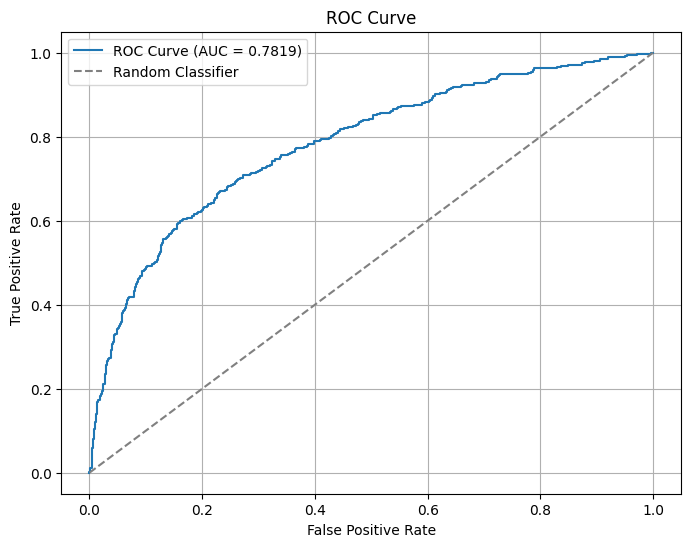

In [46]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred = best_xgb.predict(X_test)
y_pred_proba = best_xgb.predict_proba(X_test)[:, 1]  # For ROC and AUC

# Compute evaluation metrics
performance_results = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1 Score": f1_score(y_test, y_pred),
    "ROC AUC": roc_auc_score(y_test, y_pred_proba)
}

# Print performance metrics
print("\n✅ Performance of the best XGBoost model:")
for metric, value in performance_results.items():
    print(f"{metric}: {value:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {performance_results['ROC AUC']:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# **Try Adjusting the Threshold**

In [47]:
# Adjust classification threshold
threshold = 0.4  # Example threshold
y_pred_adjusted = (best_xgb.predict_proba(X_test)[:, 1] >= threshold).astype(int)

# Evaluate with adjusted threshold
from sklearn.metrics import precision_score, recall_score, f1_score
print("Adjusted Threshold (0.4):")
print("Precision:", precision_score(y_test, y_pred_adjusted))
print("Recall:", recall_score(y_test, y_pred_adjusted))
print("F1 Score:", f1_score(y_test, y_pred_adjusted))

Adjusted Threshold (0.4):
Precision: 0.5681818181818182
Recall: 0.49157303370786515
F1 Score: 0.5271084337349398


In [48]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Predict probabilities for positive class
y_pred_proba = best_xgb.predict_proba(X_test)[:, 1]

# Define thresholds to test
thresholds = np.arange(0.1, 0.5, 0.05)

# Evaluate precision, recall, and F1 score for each threshold
results = []
for threshold in thresholds:
    y_pred_adjusted = (y_pred_proba >= threshold).astype(int)
    precision = precision_score(y_test, y_pred_adjusted)
    recall = recall_score(y_test, y_pred_adjusted)
    f1 = f1_score(y_test, y_pred_adjusted)
    results.append({"Threshold": threshold, "Precision": precision, "Recall": recall, "F1 Score": f1})

# Convert results to a DataFrame for easier analysis
import pandas as pd
results_df = pd.DataFrame(results)

# Display results
print("\n✅ Threshold Performance Metrics:")
print(results_df)


✅ Threshold Performance Metrics:
   Threshold  Precision    Recall  F1 Score
0       0.10   0.409756  0.707865  0.519053
1       0.15   0.446602  0.646067  0.528129
2       0.20   0.477024  0.612360  0.536285
3       0.25   0.509662  0.592697  0.548052
4       0.30   0.526316  0.561798  0.543478
5       0.35   0.535817  0.525281  0.530496
6       0.40   0.568182  0.491573  0.527108
7       0.45   0.590747  0.466292  0.521193


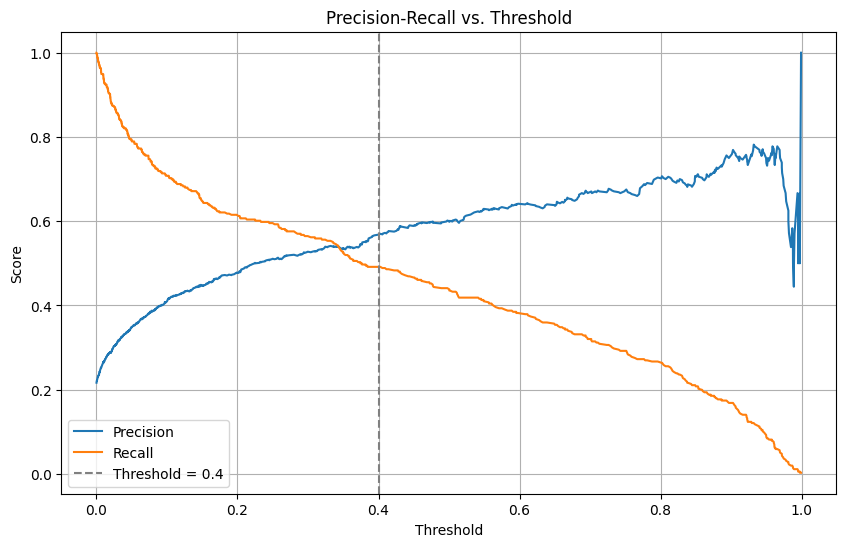

In [49]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Get precision-recall curve data
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Plot precision-recall vs. threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], label="Precision")
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.axvline(x=0.4, color="gray", linestyle="--", label="Threshold = 0.4")  # Mark current threshold
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall vs. Threshold")
plt.legend()
plt.grid(True)
plt.show()

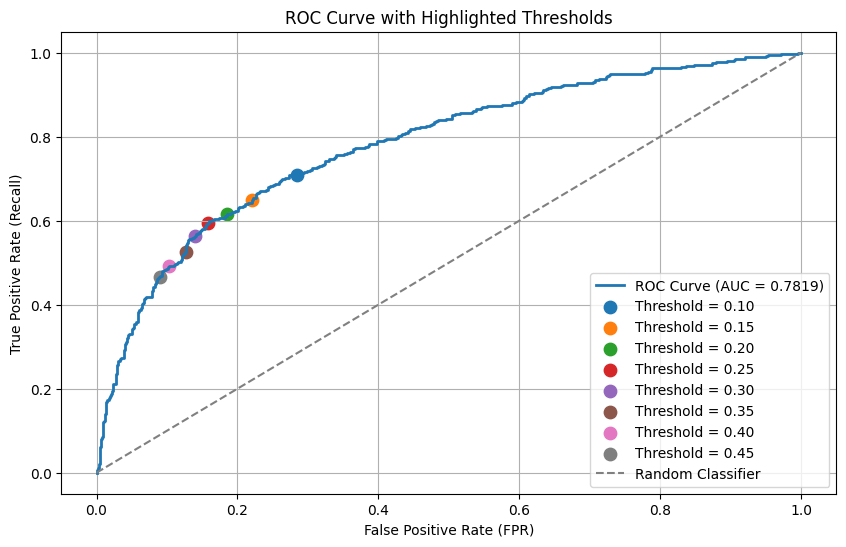

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Predict probabilities for the positive class (class 1)
y_pred_proba = best_xgb.predict_proba(X_test)[:, 1]

# Define specific thresholds
thresholds = np.arange(0.1, 0.5, 0.05)

# Calculate ROC curve
fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})", linewidth=2)

# Highlight specific thresholds on the ROC curve
for threshold in thresholds:
    closest_idx = np.argmin(np.abs(roc_thresholds - threshold))  # Find closest threshold index
    plt.scatter(fpr[closest_idx], tpr[closest_idx], label=f"Threshold = {threshold:.2f}", s=80)

# Add random classifier line
plt.plot([0, 1], [0, 1], color="gray", linestyle="--", label="Random Classifier")

# Customize the plot
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve with Highlighted Thresholds")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# **Save Environment**

In [ ]:
workflow_code = """
# ==============================
# 🔹 1. IMPORT LIBRARIES
# ==============================
import pandas as pd
import numpy as np
import joblib
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# ==============================
# 🔹 2. LOAD DATA
# ==============================
file_path = "/content/drive/My Drive/DOA-MeatDucks-SHAP/DOA-data_65-66.xlsx"
df = pd.read_excel(file_path)

# ==============================
# 🔹 3. DATA PREPROCESSING
# ==============================
# Remove invalid data points
df = df[(df['head'] > 0) & (df['head'] <= 1900)]
df = df[(df['age'] > 3) & (df['age'] <= 47)]
df = df[df['bw'] >= 2]
df = df[(df['lairagetemp'] > 0) & (df['lairagetemp'] <= 39)]
df = df[df['doa'] <= 50]

# Impute missing 'distance' by 'transportduration' (group by farm)
df['distance'] = df.groupby('farm')['transportduration'].transform(lambda x: x.fillna(x.median()))

# ==============================
# 🔹 4. FEATURE ENGINEERING
# ==============================
df['pctdoa'] = (df['doa'] / df['head']) * 100
df['orderc'] = pd.cut(df['order'], bins=[0, 5, 10, np.inf], labels=["Early", "Middle", "Late"])
df['season'] = df['date'].dt.month.map(lambda x: 'Winter' if x in [11, 12, 1, 2] else 'Summer' if x in [3, 4, 5] else 'Rainy')

# ==============================
# 🔹 5. DATA SPLITTING
# ==============================
X = df.drop(columns=['highdoa', 'date', 'order', 'farm', 'timeoutfarm', 'timearrive', 'slaughtertime', 'doa', 'pctdoa'])
y = df['highdoa']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# ==============================
# 🔹 6. HANDLE IMBALANCE WITH SMOTE
# ==============================
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# ==============================
# 🔹 7. TRAIN MODELS
# ==============================
# Logistic Regression
from sklearn.linear_model import LogisticRegression
model_lr = LogisticRegression(class_weight="balanced", random_state=42)
model_lr.fit(X_train, y_train)

# Random Forest
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(class_weight="balanced", random_state=42)
model_rf.fit(X_train, y_train)

# XGBoost
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
model_xgb = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, use_label_encoder=False, random_state=42)
model_xgb.fit(X_train, y_train)

# Deep Learning Model
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model_dl = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])
model_dl.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_dl.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=1, validation_data=(X_test_scaled, y_test))

# ==============================
# 🔹 8. SAVE TRAINED MODELS
# ==============================
joblib.dump(model_lr, "/content/drive/My Drive/DOA-MeatDucks-SHAP/model_lr.pkl")
joblib.dump(model_rf, "/content/drive/My Drive/DOA-MeatDucks-SHAP/model_rf.pkl")
joblib.dump(model_xgb, "/content/drive/My Drive/DOA-MeatDucks-SHAP/model_xgb.pkl")
model_dl.save("/content/drive/My Drive/DOA-MeatDucks-SHAP/model_dl.h5")

print("✅ All models trained and saved successfully!")
"""

# Save the script to Google Drive
with open("/content/drive/My Drive/DOA-MeatDucks-SHAP/full_pipeline.py", "w") as f:
    f.write(workflow_code)

print("✅ Full workflow saved as full_pipeline.py")

✅ Full workflow saved as full_pipeline.py


In [ ]:
!pip freeze > /content/drive/My Drive/DOA-MeatDucks-SHAP/requirements.txt

/bin/bash: line 1: /content/drive/My: Operation not supported


# **Load Environment**

In [1]:
exec(open("/content/drive/My Drive/DOA-MeatDucks-SHAP/full_pipeline.py").read())

KeyError: 'Column not found: transportduration'

In [ ]:
!pip install -r /content/drive/My Drive/DOA-MeatDucks-SHAP/requirements.txt